# Unsupervised Anomaly Detection

In [1]:
%matplotlib inline

# Filter warnings
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
plt.rcParams.update({'font.size': 15})

In [2]:
# Import custom class
%run -i '../src/helper/transfxns.py'
%run -i '../src/helper/unsup_ml.py'

# Load data

In [3]:
df = pd.read_csv('../data/kdd99-unsupervised-ad.csv', header = None)
print("Data size:", df.shape) # print data size
df.columns = ['v_{}'.format(i) for i in range(30)] # column names
df.head()

Data size: (620098, 30)


,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,...,v_20,v_21,v_22,v_23,v_24,v_25,v_26,v_27,v_28,v_29
0,0.0,215.0,45076.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,n
1,0.0,162.0,4528.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,n
2,0.0,236.0,1228.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,n
3,0.0,233.0,2032.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,n
4,0.0,239.0,486.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,n


# Categorical variables encoded as integers

In [4]:
# Convert to string
cols = ['v_6', 'v_7', 'v_8', 'v_9']
for i, val in enumerate(cols):
    df[val] = df[val].astype('O')

# Drop the class label

We will assume that the class label was not provided, which is the case in unsupervised anomaly detection problems. Therefore, the class label will be dropped. However, since the class label is given we will use it to evaluate the accuracy of the unsupervised models, but in reality this is impossible

In [5]:
 # Map to binary and save for later use
y_true = (df.v_29.map({'n':0, 'o':1})).values

In [6]:
# Drop class label
df.drop('v_29', axis =1, inplace = True)

# Transformation pipeline

In [7]:
# Instantiate the  classes
transfxn = TransformationPipeline()

In [8]:
# Transform and scale data
X_scaled, _, _ = transfxn.preprocessing(df, df)

In [9]:
print('Data size after pre-processing:', X_scaled.shape)

Data size after pre-processing: (620098, 33)


# Unsupervised Models

In [10]:
# Instantiate the class
model = UnsupervisedModels()

## 1. Isolation Forest

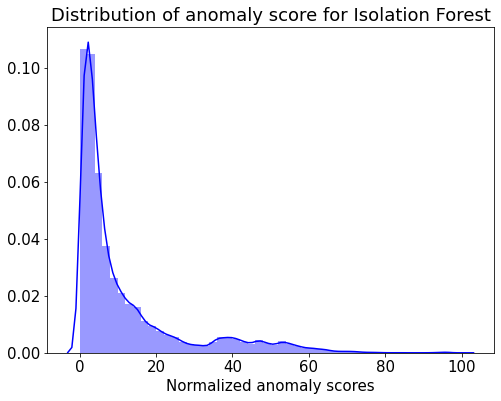

In [11]:
# Train model
if_scores, if_y_pred = model.iforest(X_scaled, n_estimators = 500, random_state= 42)

# Add anomaly score to the data
if_df = df.copy()
if_df['anomaly_score'] = if_scores

# Plot anomaly score distribution
model.plot_dist(if_df.anomaly_score, color = 'b', title = 'Distribution of anomaly score for Isolation Forest')

In [12]:
# Evaluation metric
model.eval_metric(y_true, if_y_pred)

---------------------------------------------------------------------------
Test accuracy:  0.907628
AUROC: 0.819933
AUPRC: 0.010211
Predicted classes: [0 1]
Confusion matrix:
 [[562048  56998]
 [   282    770]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95    619046
           1       0.01      0.73      0.03      1052

    accuracy                           0.91    620098
   macro avg       0.51      0.82      0.49    620098
weighted avg       1.00      0.91      0.95    620098

---------------------------------------------------------------------------


## 2. Cluster-Based Local Outlier Factor

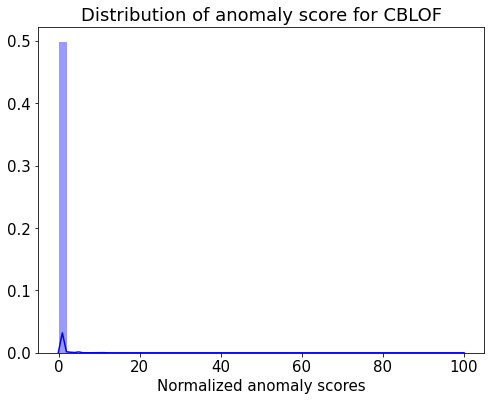

In [13]:
# Train model
cblof_scores, cblof_y_pred = model.cblof(X_scaled, contamination = 0.1, random_state = 42)

# Add anomaly score to the data
cblof_df = df.copy()
cblof_df['anomaly_score'] = cblof_scores

# Plot anomaly score distribution
model.plot_dist(cblof_df.anomaly_score, color = 'b', title = 'Distribution of anomaly score for CBLOF')

In [14]:
# Evaluation metric
model.eval_metric(y_true, cblof_y_pred)

---------------------------------------------------------------------------
Test accuracy:  0.901696
AUROC: 0.950765
AUPRC: 0.016965
Predicted classes: [0 1]
Confusion matrix:
 [[558088  60958]
 [     0   1052]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95    619046
           1       0.02      1.00      0.03      1052

    accuracy                           0.90    620098
   macro avg       0.51      0.95      0.49    620098
weighted avg       1.00      0.90      0.95    620098

---------------------------------------------------------------------------


## 3. PCA

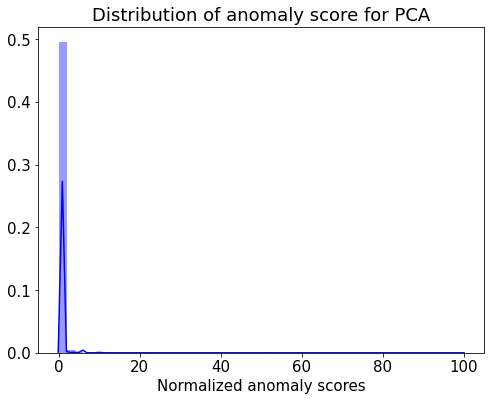

In [15]:
# Train model
pca_scores, pca_y_pred = model.pca(X_scaled, n_components = None, contamination = 0.1)

# Add anomaly score to the data
pca_df = df.copy()
pca_df['anomaly_score'] = pca_scores

# Plot anomaly score distribution
model.plot_dist(pca_df.anomaly_score, color = 'b', title = 'Distribution of anomaly score for PCA')

In [16]:
# Evaluation metric
model.eval_metric(y_true, pca_y_pred)

---------------------------------------------------------------------------
Test accuracy:  0.901696
AUROC: 0.950765
AUPRC: 0.016965
Predicted classes: [0 1]
Confusion matrix:
 [[558088  60958]
 [     0   1052]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95    619046
           1       0.02      1.00      0.03      1052

    accuracy                           0.90    620098
   macro avg       0.51      0.95      0.49    620098
weighted avg       1.00      0.90      0.95    620098

---------------------------------------------------------------------------


## 4. Elliptic Envelope

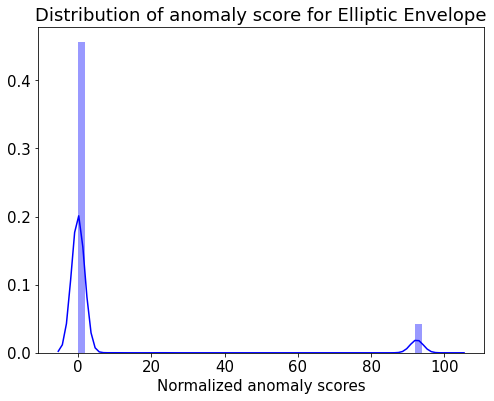

In [17]:
# Train model
ellip_scores, ellip_y_pred = model.cov(X_scaled, contamination = 0.1, random_state = 42)

# Add anomaly score to the data
ellip_df = df.copy()
ellip_df['anomaly_score'] = ellip_scores

# Plot anomaly score distribution
model.plot_dist(ellip_df.anomaly_score, color = 'b', title = 'Distribution of anomaly score for Elliptic Envelope')

In [18]:
# Evaluation metric
model.eval_metric(y_true, ellip_y_pred)

---------------------------------------------------------------------------
Test accuracy:  0.899522
AUROC: 0.629878
AUPRC: 0.003277
Predicted classes: [0 1]
Confusion matrix:
 [[557414  61632]
 [   674    378]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95    619046
           1       0.01      0.36      0.01      1052

    accuracy                           0.90    620098
   macro avg       0.50      0.63      0.48    620098
weighted avg       1.00      0.90      0.95    620098

---------------------------------------------------------------------------
